# import packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
from matplotlib.cm import ScalarMappable

from libpysal.weights import KNN, DistanceBand
from libpysal.cg import KDTree

/home/liaom/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-1-619e707abcca>:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (cal

# Data Input

In [2]:
# read survey data
care_df = pd.read_csv('caresurveydata_Oshan_012524.csv')

In [3]:
# read census tracts in DC
dc_census_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_11_tract.zip")
care_gdf = gpd.GeoDataFrame(care_df.copy(), geometry=gpd.points_from_xy(care_df.lon_new, care_df.lat_new), crs = dc_census_tract.crs)

# Reproject the D.C. boundary data to the projected coordinate system "MD State Plane NAD 83"
care_gdf_rprj = care_gdf.to_crs("EPSG:6487")
dc_census_tract_rprj = dc_census_tract.to_crs("EPSG:6487")

In [4]:
care_df.columns

Index(['pseudoid', 'respond_type', 'surv_lang', 'lon_new', 'lat_new', 'WARD',
       'TRACT_new', 'GEOID_new', 'BLKGRP_new', 'FIPS.Code', 'Block', 'age',
       'gender', 'SES_ladder_NH', 'cohes_avg', 'ERI_res_expl_total',
       'race_eth_category_a', 'income_a', 'marital_a', 'education_a',
       'life_satisfaction_1_a', 'SES_ladder_USA_a', 'materialhardship_tot_a',
       'place_attachment_avg_a', 'ISC_avg_a', 'NH_CE_avg_a',
       'NH_safety_avg_a'],
      dtype='object')

# Geographically Weighted Correlation Coefficients

In [5]:
care_gdf_rprj_nonan = care_gdf_rprj.copy()
care_gdf_rprj_nonan = care_gdf_rprj_nonan[~care_gdf_rprj_nonan.NH_safety_avg_a.isna()]
care_gdf_rprj_nonan = care_gdf_rprj_nonan[~care_gdf_rprj_nonan.place_attachment_avg_a.isna()]
corr_gdf = care_gdf_rprj_nonan.reset_index().copy()

In [6]:
coords = np.array([(point.x, point.y) for point in corr_gdf.geometry])
kd_tree = KDTree(coords)
w = KNN(kd_tree, 50)

zsa = (corr_gdf['NH_safety_avg_a'] - corr_gdf['NH_safety_avg_a'].mean()) / corr_gdf['NH_safety_avg_a'].std()
zpa = (corr_gdf['place_attachment_avg_a'] - corr_gdf['place_attachment_avg_a'].mean()) / corr_gdf['place_attachment_avg_a'].std()

gwcc_results = pd.DataFrame(index=corr_gdf.index, columns=['GWCC_sa_pa'])

# Calculate GWCC for each location
for i in corr_gdf.index:

    neighbors = w.neighbors[i]
   
    weights = np.array(w.weights[i])

    local_sa = zsa.iloc[neighbors]
    local_pa = zpa.iloc[neighbors]
    
    # Calculate the weighted correlation coefficient
    weighted_covariance_sa_pa = np.sum(weights * (local_sa - local_sa.mean()) * (local_pa - local_pa.mean())) / np.sum(weights)

    weighted_sa = np.sum(weights * (local_sa - local_sa.mean())**2) / np.sum(weights)
    weighted_pa = np.sum(weights * (local_pa - local_pa.mean())**2) / np.sum(weights)

    gwcc_sa_pa = weighted_covariance_sa_pa / np.sqrt(weighted_sa * weighted_pa)

    # Store the result
    gwcc_results.loc[i, 'GWCC_sa_pa'] = gwcc_sa_pa
    
corr_gdf = corr_gdf.join(gwcc_results)

/home/liaom/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


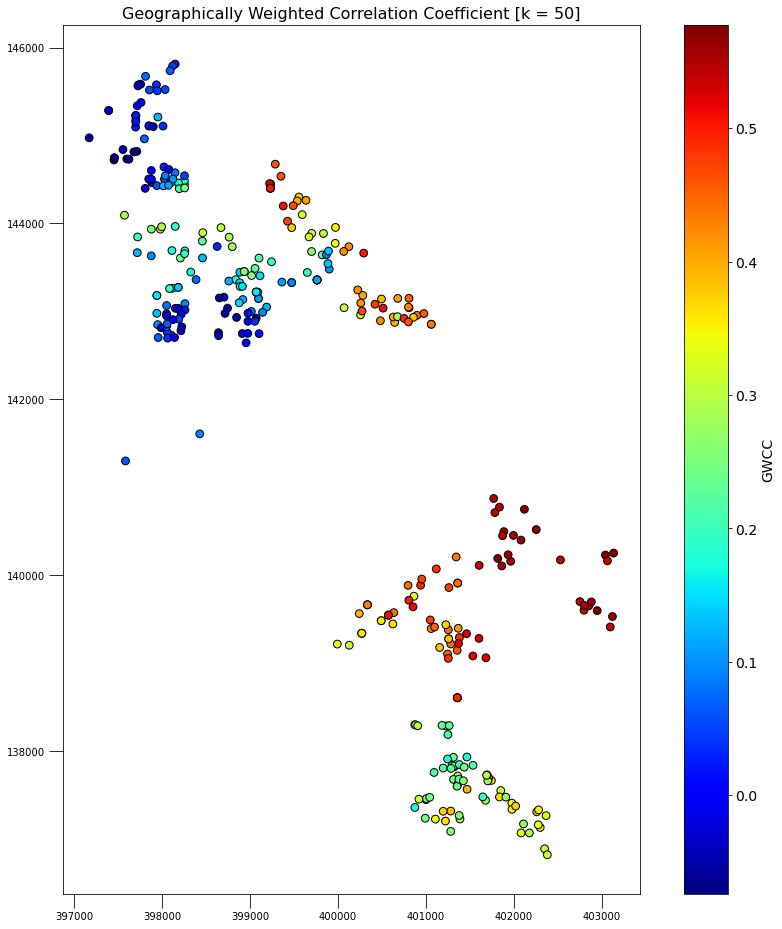

In [7]:
fig, ax = plt.subplots(figsize = (16,16))
ax.tick_params(size = 14)
corr_gdf.plot(column='GWCC_sa_pa', ax=ax, cmap='jet', edgecolor='black', markersize = 60)

norm = Normalize(vmin=corr_gdf['GWCC_sa_pa'].min(), vmax=corr_gdf['GWCC_sa_pa'].max())
cmap = plt.cm.jet
ax.set_title('Geographically Weighted Correlation Coefficient [k = 50]', fontsize = 16)
sm = ScalarMappable(norm=norm, cmap=cmap)

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('GWCC', fontsize=14)
cbar.ax.tick_params(labelsize=14) 
# plt.savefig("results/gwcc_sa_pa_whole.png", dpi = 300)

plt.show()